In [1]:
%config IPCompleter.greedy = True
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
    
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.colors as colors

import senpy as sp
from senpy import cmap


In [2]:
## 
time_slice = slice('1979-01', '2022-12')

prec_ds = xr.open_dataset('/export/epekema/zhaos/data/sst/ERSSTv5/sst.mon.mean_1x1.nc').sel(time=time_slice)['sst']
prec_ds = prec_ds.reindex(lat=sorted(prec_ds.lat))
prec_ds = sp.add_cyclic_point(prec_ds, dim = 'lon')
prec_m = prec_ds.groupby('time.month').mean()
prec_a = prec_ds.groupby('time.month') - prec_m
prec_stddev = prec_a.std('time')

group_var = {
    'All-Months': prec_m.mean('month'),
    'DJF': prec_m.sel(month=[12, 1, 12]).mean('month'),
    'MAM': prec_m.sel(month=[3, 4, 5]).mean('month'),
    'JJA': prec_m.sel(month=[6, 7, 8]).mean('month'),
    'SON': prec_m.sel(month=[9, 10, 11]).mean('month'),
}

In [3]:
# fig = cmap.listview_cmaps()

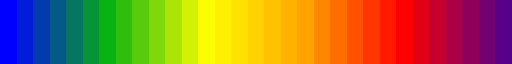

In [4]:
prC_clevs, prC_cmap, prC_norm = cmap.level_cmap_norms(name='BlGrYeOrReVi200', reverse=False,
                                                      levels=np.arange(0, 30, step=1),
                                                      extend='both',)


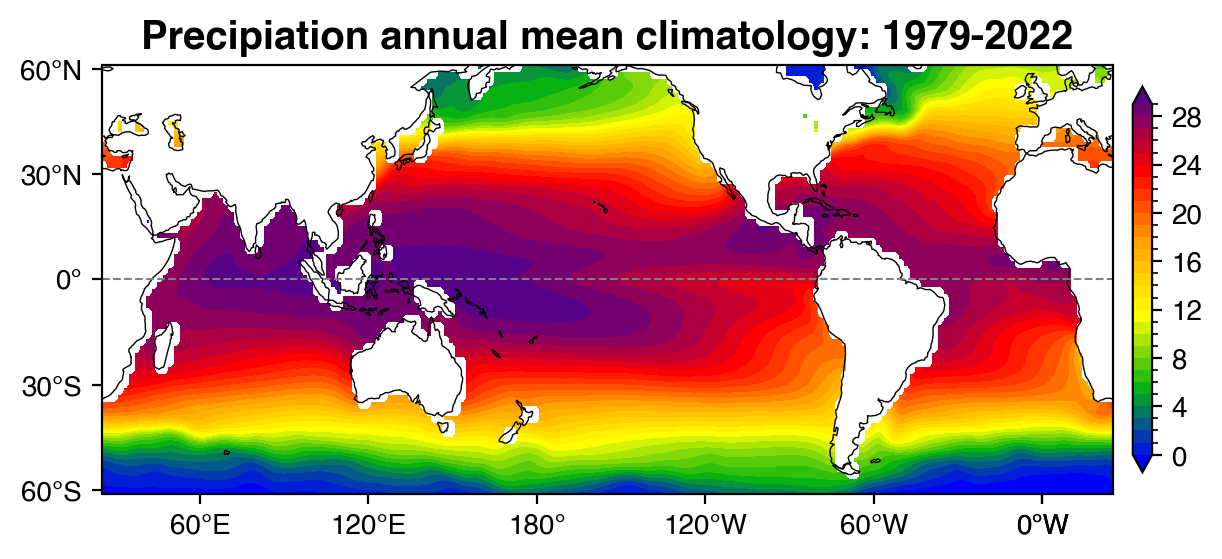

In [5]:
# fig, axes = sp.map_subplots( 2, 2, figsize=(12, 5), proj='robin', lon_0=205, aspect=1.)
# fig, axes = sp.map_subplots( 2, 2, figsize=(12, 12), proj='lambertcyl', lon_0=205, aspect=1.)
# fig, ax = sp.map_subplots( 1, 1, figsize=(6, 3), proj='lambertcyl', lon_0=180, aspect=1.5, layout='compressed')
fig, ax = sp.map_subplots( 1, 1, figsize=(6, 4), proj='cyl', lon_0=205, aspect=1.25, layout='compressed')

sea = 'All-Months'
var_ds = group_var[sea]

imag0 = ax.contourf(var_ds.lon, var_ds.lat, var_ds, 
            levels=prC_clevs, cmap=prC_cmap, norm=prC_norm, extend='both',
            transform=sp.data_crs)
# ax.pcolormesh(var_ds.lon, var_ds.lat, var_ds, cmap=prC_cmap, norm=prC_norm, transform=sp.data_crs)
sp.map_coastline(ax, scale='110m', color='black')
sp.map_equator(ax,)
sp.map_ticks(ax, lat_lim=[-61, 61])

cb = fig.colorbar(imag0, ax=[ax], location='right', shrink=0.9, pad=0.02)
cb.set_ticks(prC_clevs[::4])
cb.ax.set_yticklabels(["{:g}".format(i) for i in cb.get_ticks()])
# cb = fig.colorbar(imag0, ax=[ax], location='bottom', shrink=0.8, pad=0.02)
# cb.set_ticks(prC_clevs)
# cb.ax.set_xticklabels(["{:g}".format(i) for i in cb.get_ticks()])

ax.set_title('Precipiation annual mean climatology: 1979-2022', fontsize='x-large', fontweight='bold')
sp.savefig(fig, 'Clim_sst_ann.pdf')

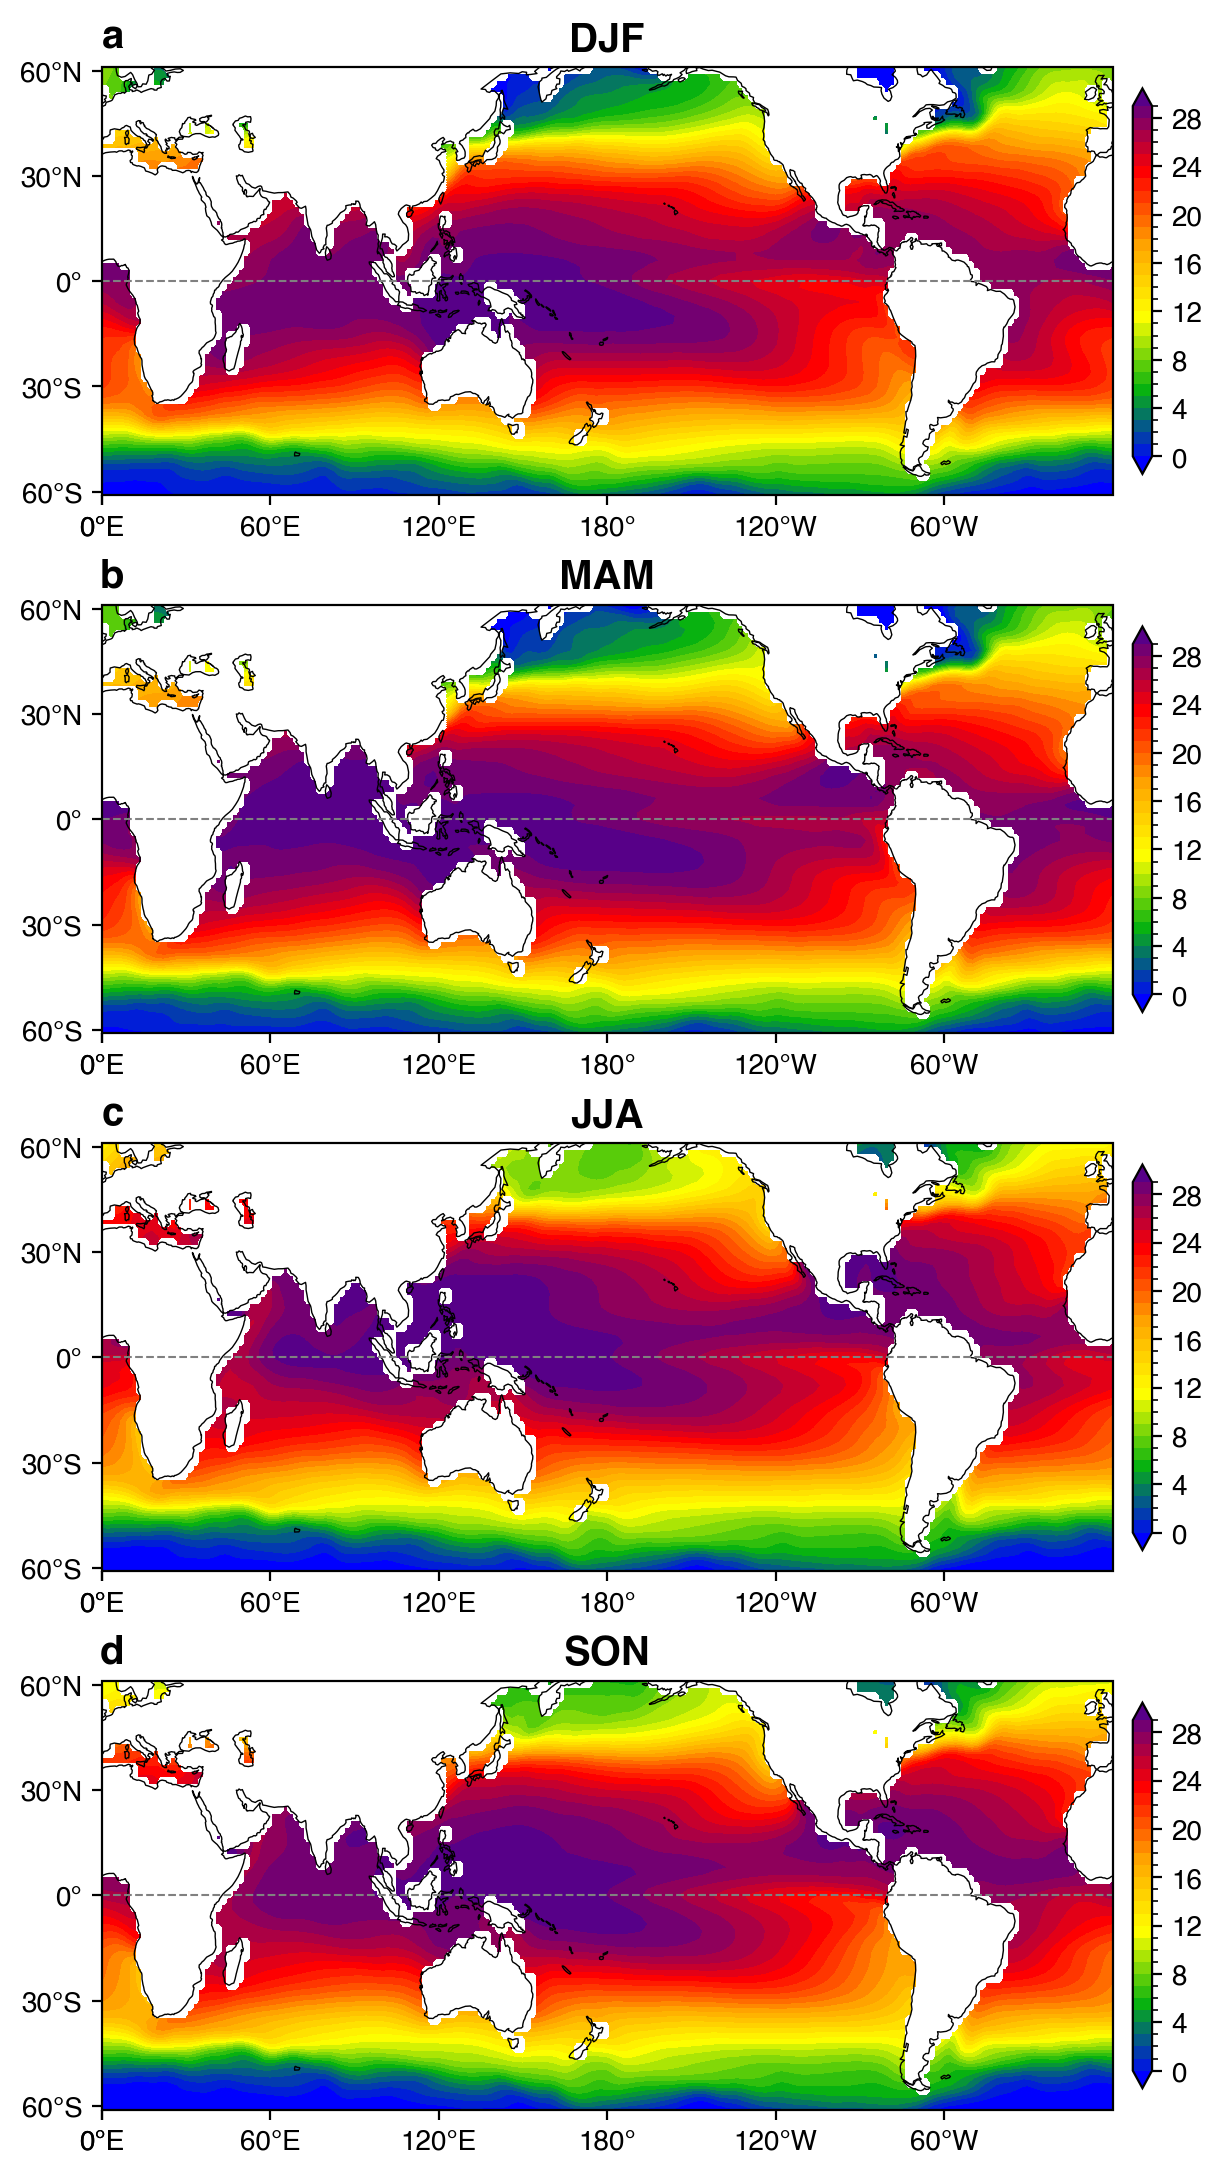

In [6]:
# fig, axes = sp.map_subplots( 2, 2, figsize=(12, 5), proj='robin', lon_0=205, aspect=1.)
# fig, axes = sp.map_subplots( 2, 2, figsize=(12, 12), proj='lambertcyl', lon_0=205, aspect=1.)
# fig, axes = sp.map_subplots( 4, 1, figsize=(6, 11), proj='lambertcyl', lon_0=180, aspect=1.5, layout='compressed')
fig, axes = sp.map_subplots( 4, 1, figsize=(6, 12), proj='cyl', lon_0=180, aspect=1.25, layout='compressed')

for i, sea in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = axes.flat[i]
    var_ds = group_var[sea]
    
    imag0 = ax.contourf(var_ds.lon, var_ds.lat, var_ds, 
                levels=prC_clevs, cmap=prC_cmap, norm=prC_norm, extend='both',
                transform=sp.data_crs)
    # ax.pcolormesh(var_ds.lon, var_ds.lat, var_ds, cmap=prC_cmap, norm=prC_norm, transform=sp.data_crs)
    sp.map_coastline(ax, scale='110m', color='black')
    sp.map_equator(ax,)
    sp.map_ticks(ax, lat_lim=[-61, 61])
    ax.set_title(sea, fontsize='x-large', fontweight='bold')

    cb = fig.colorbar(imag0, ax=[ax], location='right', shrink=0.9, pad=0.02)
    cb.set_ticks(prC_clevs[::4])
    cb.ax.set_yticklabels(["{:g}".format(i) for i in cb.get_ticks()])

    # cb = fig.colorbar(imag0, ax=[ax], location='bottom', shrink=0.8, pad=0.02)
    # cb.set_ticks(prC_clevs)
    # cb.ax.set_xticklabels(["{:g}".format(i) for i in cb.get_ticks()])

sp.set_legend_alphabet(fig, axes.flat, x=0.05, y=0.98)
sp.savefig(fig, 'Clim_sst_seasons.pdf')

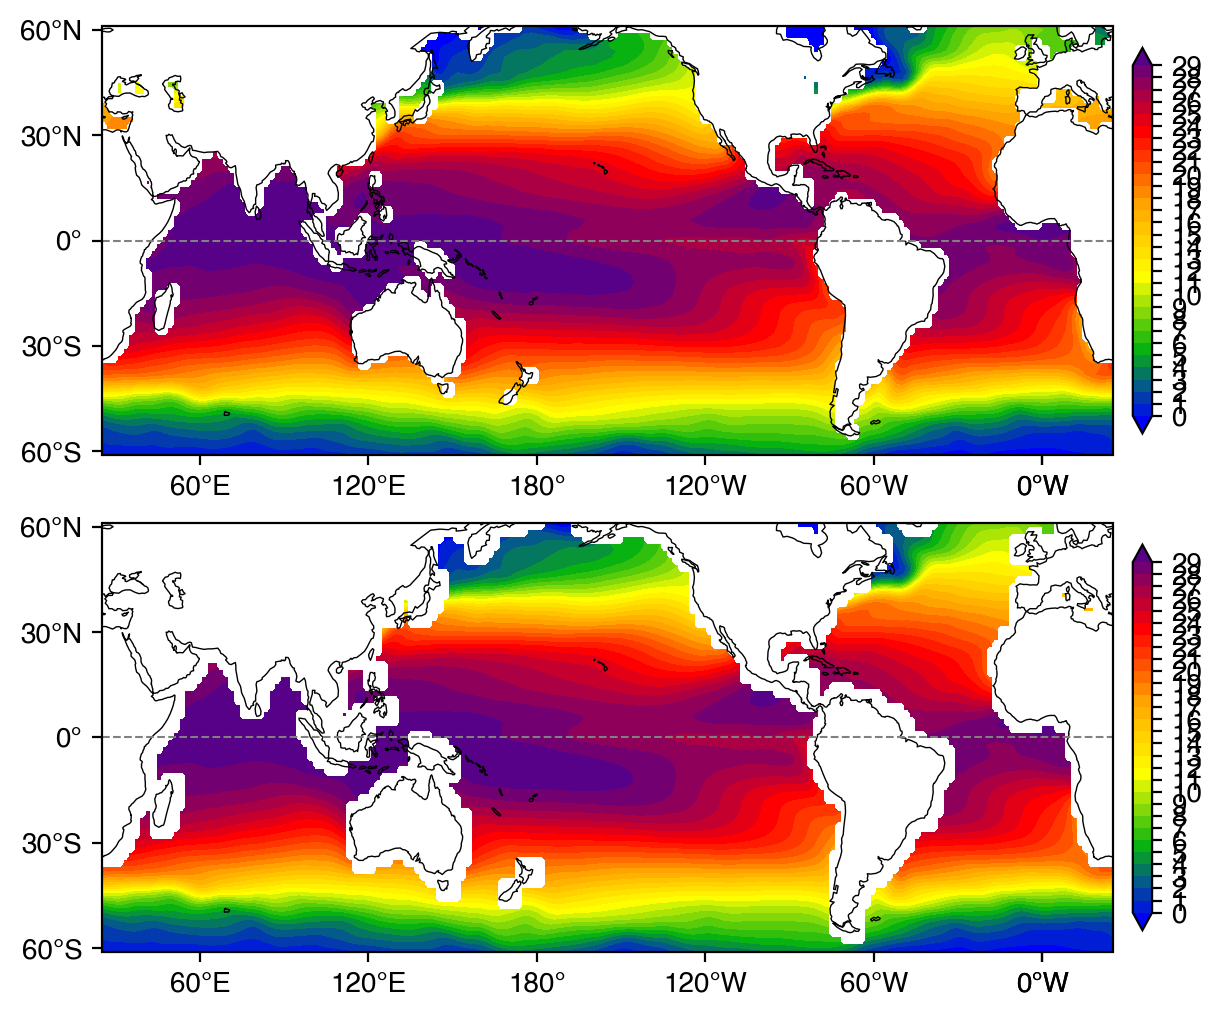

In [7]:
from scipy.ndimage import gaussian_filter
def smooth_gaussian(scalar_grid, n):
    # Compute standard deviation in a manner consistent with GEMPAK
    n = int(round(n))
    n = max(n, 2)
    sgma = n / (2 * np.pi)

    # Construct sigma sequence so smoothing occurs only in horizontal direction
    num_ax = len(scalar_grid.shape)
    # Assume the last two axes represent the horizontal directions
    sgma_seq = [sgma if i > num_ax - 3 else 0 for i in range(num_ax)]

    filter_args = {'sigma': sgma_seq, 'truncate': 2 * np.sqrt(2)}
    if hasattr(scalar_grid, 'mask'):
        smoothed = gaussian_filter(scalar_grid.data, **filter_args)
        return np.ma.array(smoothed, mask=scalar_grid.mask)
    else:
        return gaussian_filter(scalar_grid, **filter_args)



# fig, axes = sp.map_subplots( 2, 2, figsize=(12, 5), proj='robin', lon_0=205, aspect=1.)
# fig, axes = sp.map_subplots( 2, 2, figsize=(12, 12), proj='lambertcyl', lon_0=205, aspect=1.)
# fig, ax = sp.map_subplots( 1, 1, figsize=(6, 3), proj='lambertcyl', lon_0=180, aspect=1.5, layout='compressed')
fig, axes = sp.map_subplots( 2, 1, figsize=(6, 8), proj='cyl', lon_0=205, aspect=1.25, layout='compressed')

ds_lists = list( [ group_var['MAM'], xr.apply_ufunc(smooth_gaussian, group_var['MAM'], kwargs={'n': 4}) ])

for i, ax in enumerate(axes.flat):
    var_ds = ds_lists[i]
    imag0 = ax.contourf(var_ds.lon, var_ds.lat, var_ds, 
                levels=prC_clevs, cmap=prC_cmap, norm=prC_norm, extend='both',
                transform=sp.data_crs)
    # ax.pcolormesh(var_ds.lon, var_ds.lat, var_ds, cmap=prC_cmap, norm=prC_norm, transform=sp.data_crs)
    sp.map_coastline(ax, scale='110m', color='black')
    sp.map_equator(ax,)
    sp.map_ticks(ax, lat_lim=[-61, 61])
    
    cb = fig.colorbar(imag0, ax=[ax], location='right', shrink=0.9, pad=0.02)
    cb.set_ticks(prC_clevs)
    cb.ax.set_yticklabels(["{:g}".format(i) for i in cb.get_ticks()])
    # cb = fig.colorbar(imag0, ax=[ax], location='bottom', shrink=0.8, pad=0.02)
    # cb.set_ticks(prC_clevs)
    # cb.ax.set_xticklabels(["{:g}".format(i) for i in cb.get_ticks()])
    
    # ax.set_title('Precipiation annual mean climatology: 1979-2022', fontsize='x-large', fontweight='bold')
